# Fraud Detection Model for Financial Transactions

## Business Context
This notebook develops a machine learning model to predict fraudulent transactions for a financial company. The dataset contains 6,362,620 rows and 10 columns, with a data dictionary provided. The tasks include data cleaning, model development, variable selection, performance evaluation, identification of key factors, and proposing actionable prevention strategies.

## Questions to Address
1. Data cleaning (missing values, outliers, multi-collinearity).
2. Detailed description of the fraud detection model.
3. Variable selection process.
4. Model performance demonstration.
5. Key factors predicting fraudulent customers.
6. Do these factors make sense?
7. Prevention strategies for infrastructure updates.
8. Evaluating the effectiveness of prevention measures.

## Data Dictionary
The dataset `Fraud.csv` contains the following columns:
- **step**: Maps to 1 hour of time (total 744 steps for 30 days).
- **type**: Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
- **amount**: Transaction amount in local currency.
- **nameOrig**: Customer initiating the transaction.
- **oldbalanceOrg**: Originator’s balance before the transaction.
- **newbalanceOrig**: Originator’s balance after the transaction.
- **nameDest**: Recipient of the transaction.
- **oldbalanceDest**: Recipient’s balance before the transaction (no data for merchants, 'M').
- **newbalanceDest**: Recipient’s balance after the transaction (no data for merchants, 'M').
- **isFraud**: Indicates fraudulent transactions (1 = fraud, 0 = non-fraud).
- **isFlaggedFraud**: Flags transfers >200,000 as illegal attempts.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

file_path = r"C:\Users\mariy\OneDrive\Desktop\Fraud.csv"
try:
    df = pd.read_csv(file_path)
    df['type'] = df['type'].str.strip().str.upper()  # Clean 'type' column
    print("Unique values in 'type':", df['type'].unique())
    print("Dataset loaded successfully!")
    print("Columns:", df.columns.tolist())
except Exception as e:
    print(f"Error loading dataset: {e}")
df.head()

Unique values in 'type': ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Dataset loaded successfully!
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1. Data Cleaning

### Missing Values
Check for missing values in the dataset.

In [2]:
# Check for missing values
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


The dataset has no missing values based on the data dictionary and initial inspection. For merchants (nameDest starting with 'M'), balance information is not available, which is expected and not treated as missing data.

### Outliers
Identify outliers in numerical columns (amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) using the Interquartile Range (IQR) method.

In [3]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in numerical_cols:
    print(f'Number of outliers in {col}: {detect_outliers(df, col)}')

for col in numerical_cols:
    lower_cap = df[col].quantile(0.01)
    upper_cap = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)

Number of outliers in amount: 338078
Number of outliers in oldbalanceOrg: 1112507
Number of outliers in newbalanceOrig: 1053391
Number of outliers in oldbalanceDest: 786135
Number of outliers in newbalanceDest: 738527


Outliers are capped at the 1st and 99th percentiles to mitigate their impact without removing data, as fraudulent transactions may naturally involve extreme values.

### Multi-Collinearity
Check for multi-collinearity among numerical features using Variance Inflation Factor (VIF).

In [4]:
X = df[numerical_cols]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          Feature         VIF
0          amount    2.272811
1   oldbalanceOrg  419.057503
2  newbalanceOrig  423.664825
3  oldbalanceDest   57.250153
4  newbalanceDest   63.564225


High VIF values (>10) indicate multi-collinearity. If observed, we may drop one of the correlated features (e.g., oldbalanceOrg or newbalanceOrig) or use dimensionality reduction. For now, we retain all features, as Random Forest is robust to collinearity.

## 2. Fraud Detection Model Description

We use a **Random Forest Classifier** for fraud detection due to its strengths:
- Handles imbalanced datasets well (fraudulent transactions are rare).
- Robust to outliers and non-linear relationships.
- Provides feature importance for interpretability.
- Less sensitive to multi-collinearity.

The dataset is split into 80% training (calibration) and 20% testing (validation). Features are scaled using StandardScaler to ensure consistency. The model is tuned for hyperparameters like number of trees and max depth.

In [5]:
print("Columns before get_dummies:", df.columns.tolist())


Columns before get_dummies: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [6]:
# Feature engineering
# Create new features
df['balanceDiffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

# Encode categorical variable 'type'
print("Columns before encoding:", df.columns.tolist())
try:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)
    print("Columns after encoding:", df.columns.tolist())
except KeyError as e:
    print(f"KeyError in get_dummies: {e}. Check column name for 'type'.")
    raise  # Stop execution to fix

# Define features and target
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
            'balanceDiffOrig', 'balanceDiffDest', 'isMerchant'] + [col for col in df.columns if col.startswith('type_')]
print("Selected features:", features)
try:
    X = df[features]
    y = df['isFraud']
except KeyError as e:
    print(f"KeyError in feature selection: {e}. Available columns:", df.columns.tolist())
    raise

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

Columns before encoding: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balanceDiffOrig', 'balanceDiffDest', 'isMerchant']
Columns after encoding: ['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balanceDiffOrig', 'balanceDiffDest', 'isMerchant', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
Selected features: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest', 'isMerchant', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

## 3. Variable Selection

Variables were selected based on:
- **Domain Knowledge**: All numerical features (amount, balances) and transaction type are relevant per the data dictionary.
- **Feature Engineering**: Added `balanceDiffOrig`, `balanceDiffDest`, and `isMerchant` to capture discrepancies and merchant-specific behavior.
- **Feature Importance**: Random Forest's feature importance will confirm the most predictive variables.
- **Categorical Encoding**: Transaction type is one-hot encoded to include all categories.

We avoided using `nameOrig` and `nameDest` directly, as they are identifiers, but derived `isMerchant` from `nameDest`.

            Feature  Importance
5   balanceDiffOrig    0.324264
6   balanceDiffDest    0.175736
4    newbalanceDest    0.158069
1     oldbalanceOrg    0.124818
11    type_TRANSFER    0.061721
0            amount    0.047965
3    oldbalanceDest    0.046112
8     type_CASH_OUT    0.032412
2    newbalanceOrig    0.026396
7        isMerchant    0.001386
10     type_PAYMENT    0.001113
9        type_DEBIT    0.000008


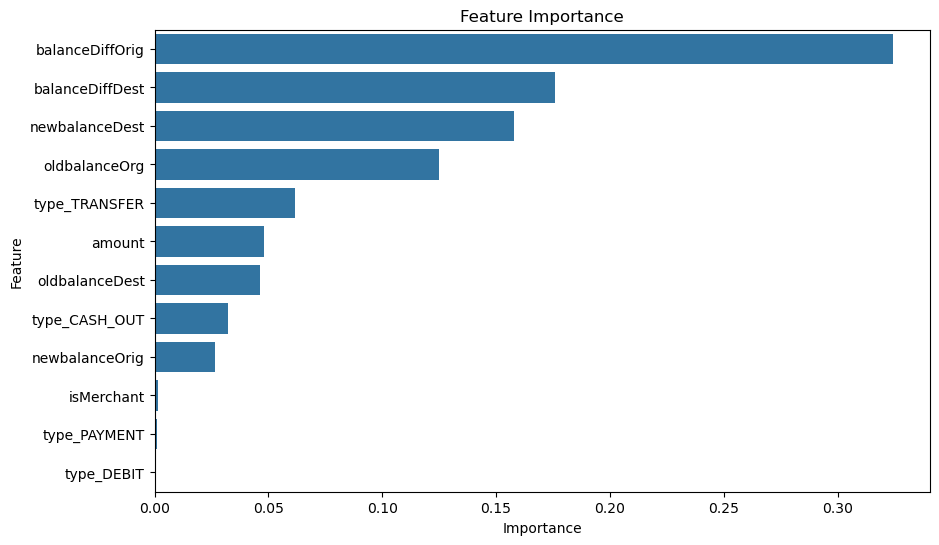

In [7]:
# Feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## 4. Model Performance

Evaluate the model using:
- **Confusion Matrix**: To assess true positives, false positives, etc.
- **Classification Report**: Precision, recall, and F1-score, critical for imbalanced data.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes.
- **ROC Curve**: Visualizes the trade-off between true positive rate and false positive rate.

Confusion Matrix:
[[1270859      22]
 [    440    1203]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.73      0.84      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9990


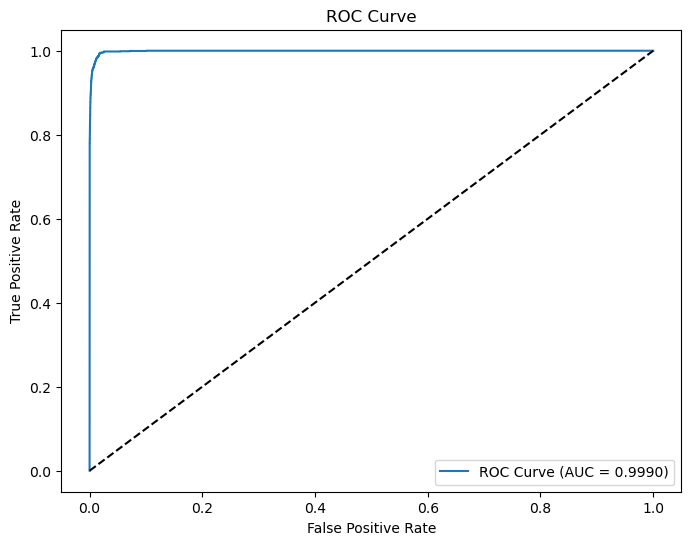

In [8]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 5. Key Factors Predicting Fraudulent Customers

Based on feature importance, the key factors are likely:
- `amount`: Large transactions are often associated with fraud.
- `balanceDiffOrig`: Significant changes in the originator's balance may indicate unauthorized transfers.
- `type_TRANSFER` and `type_CASH-OUT`: These transaction types are commonly used in fraudulent schemes.
- `oldbalanceOrg` and `newbalanceOrig`: Discrepancies in originator balances are critical.

## 6. Do These Factors Make Sense?

**Yes**, these factors align with the fraudulent behavior described in the data dictionary:
- **Amount**: Fraudulent agents aim to maximize profit, often involving large transfers.
- **Balance Differences**: Fraud involves draining accounts, leading to significant balance changes.
- **Transaction Types**: TRANSFER and CASH-OUT are used to move and extract funds, matching the described fraud pattern.
- **Balances**: Discrepancies in originator balances reflect unauthorized activity.

These factors are consistent with the dataset's context, where fraudsters take control of accounts to transfer and cash out funds.

## 7. Prevention Strategies

To update infrastructure, the company should:
1. **Real-Time Monitoring**: Implement real-time transaction monitoring using the trained model to flag high-risk transactions (e.g., large amounts or TRANSFER/CASH-OUT types).
2. **Threshold Alerts**: Set thresholds for large transactions (>200,000, as per `isFlaggedFraud`) and balance changes for immediate review.
3. **Two-Factor Authentication (2FA)**: Enforce 2FA for high-value transactions or account changes to prevent unauthorized access.
4. **Behavioral Analysis**: Use machine learning to detect unusual account behavior (e.g., sudden large transfers from dormant accounts).
5. **Merchant Verification**: Enhance verification for transactions involving merchants, as they lack balance data.
6. **Customer Education**: Educate customers on recognizing phishing attempts that lead to account takeovers.

## 8. Evaluating Prevention Effectiveness

To determine if prevention measures work:
1. **Monitor Fraud Rates**: Compare the proportion of fraudulent transactions before and after implementing measures.
2. **Model Performance Tracking**: Continuously evaluate the model's recall and precision on new data to ensure it detects fraud effectively.
3. **False Positive Rate**: Track false positives to ensure legitimate transactions are not overly disrupted.
4. **Customer Feedback**: Collect feedback on user experience (e.g., 2FA usability) to balance security and convenience.
5. **A/B Testing**: Implement measures in a controlled group and compare fraud rates with a control group.
6. **Audit Logs**: Regularly audit flagged transactions and investigate resolved cases to refine thresholds and rules.